## Imports and dataset load

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from keras import layers, losses, regularizers
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, GlobalAveragePooling2D
from keras.applications import DenseNet169
from keras.optimizers import SGD

# Change figure aesthetics
# sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset preparation

In [ ]:
# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')

In [ ]:
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Keys in the dataset:\n', list(dataset_zip.keys()))
print('Metadata:\n', list(metadata.keys()))

Keys in the dataset:
 ['metadata', 'imgs', 'latents_classes', 'latents_values']
Metadata:
 [b'date', b'description', b'version', b'latents_names', b'latents_possible_values', b'latents_sizes', b'author', b'title']


In [ ]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:], np.array([1,])))

## Helper functions

In [ ]:
def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples


def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

def show_density(imgs):
    _, ax = plt.subplots()
    ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

## Sampling

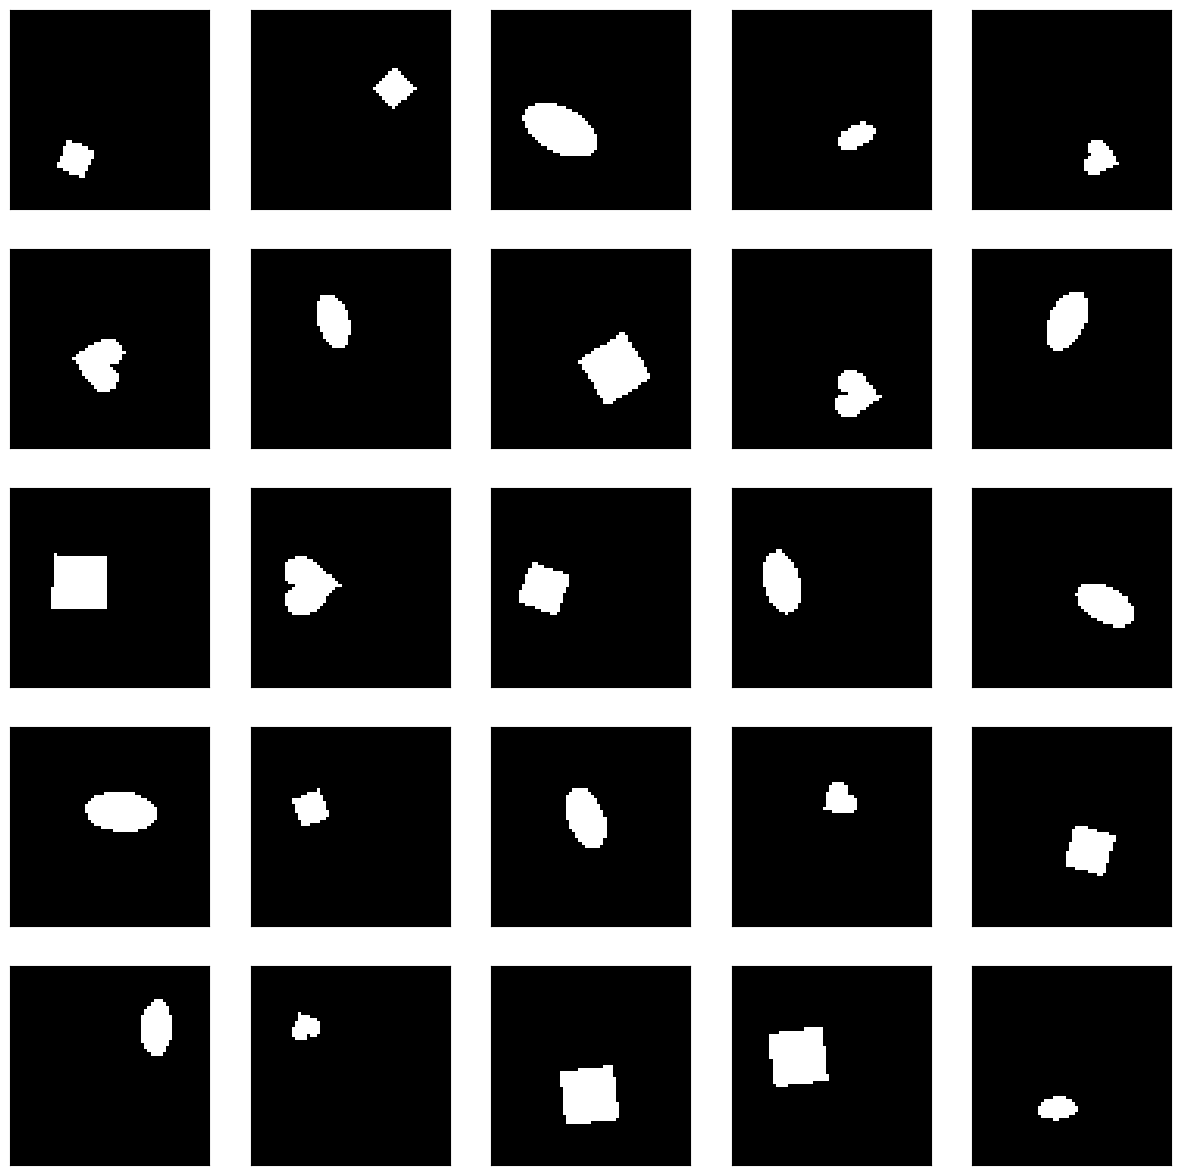

In [ ]:
# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled)

## Conditional sampling of the dataset

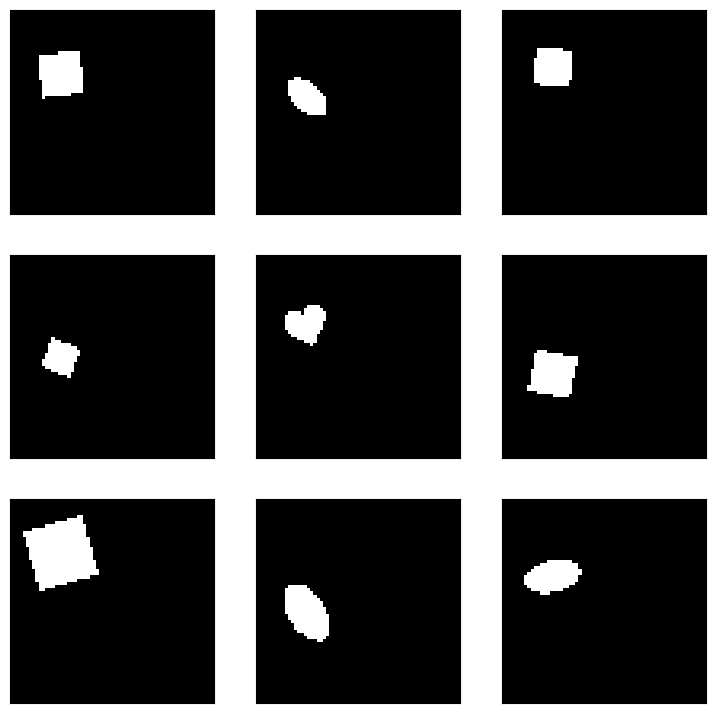

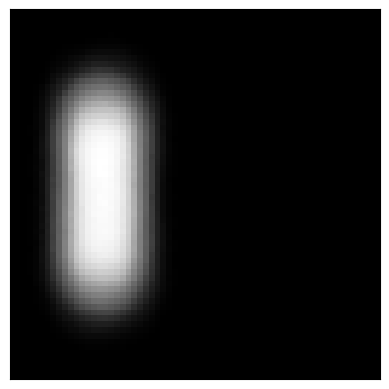

In [ ]:
## Fix posX latent to left
latents_sampled = sample_latent(size=5000)
latents_sampled[:, -2] = 0
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Show the density too to check
show_density(imgs_sampled)

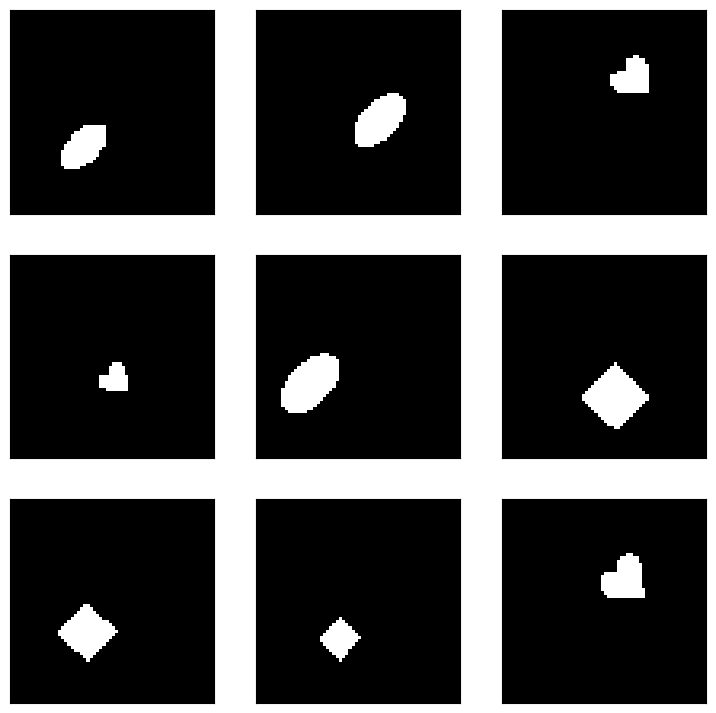

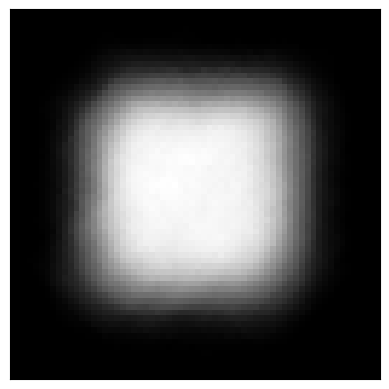

In [ ]:
## Fix orientation to 0.8 rad
latents_sampled = sample_latent(size=5000)
latents_sampled[:, 3] = 5
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Samples
show_images_grid(imgs_sampled, 9)

# Density should not be different than for all orientations
show_density(imgs_sampled)

## Preprocessing

In [ ]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    array = array.astype("float32")

    # add 1 channel
    array = np.reshape(array, (len(array), array.shape[1], array.shape[2], 1))
    return array

# Normalize and reshape the data for training:
latents_sampled_ = sample_latent(size=60000)

# Select images
indices_sampled_ = latent_to_index(latents_sampled_)
imgs_sampled_ = imgs[indices_sampled_]
x_train = preprocess(imgs_sampled_)

# Normalize and reshape the data for testing:
latents_sampled = sample_latent(size=10000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]
x_test = preprocess(imgs_sampled)

In [ ]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, marker="o", c="red", label='Training loss')
    plt.plot(val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()

    plt.show()

def plot_examples(x_test, decoded_imgs, n = 10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_pca_latent_space(encoded_imgs, labels):

    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(encoded_imgs)

    x, y = data_reduced[:, 0], data_reduced[:, 1]

    plt.figure(figsize=(8, 6), dpi=80)

    df = pd.DataFrame({'x': x, 'y':y, 'c':labels})

    pdf = df[df['c']==0]
    plt.scatter(pdf['x'], pdf['y'], label='square', alpha=0.5)

    pdf = df[df['c']==1]
    plt.scatter(pdf['x'], pdf['y'], label='ellipse', alpha=0.5)

    pdf = df[df['c']==2]
    plt.scatter(pdf['x'], pdf['y'], label='heart', alpha=0.5)
    # plt.scatter(x, y, c=labels, cmap='viridis')

    plt.title("Representation wrt labels")
    plt.legend()
    plt.show()

# Autoencoder class

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim


        self.encoder = tf.keras.Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(latent_dim),
        ])


        self.decoder = tf.keras.Sequential([
          Dense(latent_dim, activation='relu'),
          Dense(128, activation='relu'),
          Dense(4096, activation='sigmoid'),
          Reshape((64, 64))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train and plot

In [ ]:
def train_and_plot(latent_dim, epochs = 20):
    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=0.0001),
                        loss=losses.binary_crossentropy)

    history = autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10) # early stop
        ])

    plot_loss(history)

    return autoencoder

In [ ]:
def show_samples(autoencoder):
    encoded_imgs = autoencoder.encoder(x_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    plot_examples(x_test, decoded_imgs)
    return encoded_imgs, decoded_imgs

In [ ]:
def show_latent_space():
    # Flatten images for clustering
    flattened_imgs = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

    # Perform k-means clustering
    k = 3  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(flattened_imgs)

    # Calculate purity with respect to true labels
    def purity_score(y_true, y_pred):
        contingency_matrix = np.zeros((k, k))
        for i in range(len(y_true)):
            contingency_matrix[y_pred[i], y_true[i]] += 1
        purity = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
        return purity

    # Calculate purity with respect to true labels
    purity = purity_score(latents_sampled[:, 1].astype(int), cluster_labels)
    print("Purity:", purity)

    plot_pca_latent_space(encoded_imgs, latents_sampled[:, 1].astype(int))

# Different latent dimentions

#### Latent dimention 128:

Epoch 1/20
1875/1875 [==============================] - 13s 5ms/step - loss: 0.0800 - val_loss: 0.0332
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0316 - val_loss: 0.0296
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0269 - val_loss: 0.0241
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0217 - val_loss: 0.0198
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0184 - val_loss: 0.0174
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0154 - val_loss: 0.0151
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0

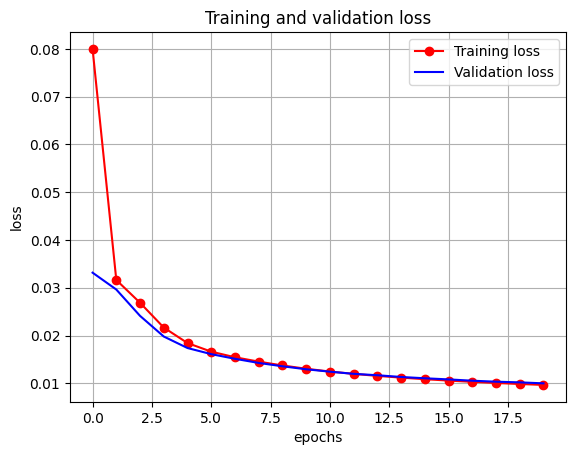

In [ ]:
autoencoder = train_and_plot(latent_dim=128, epochs = 20)

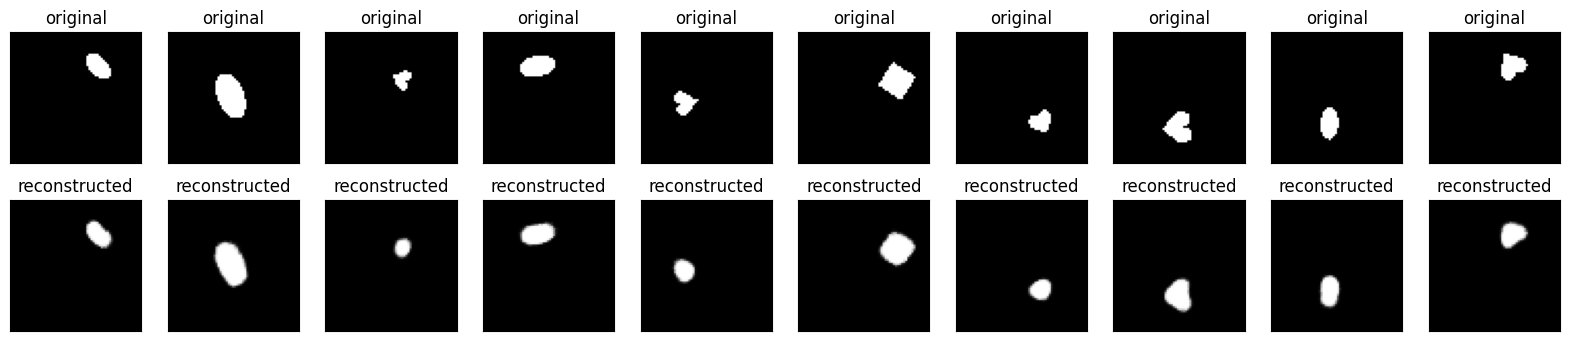

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.5268


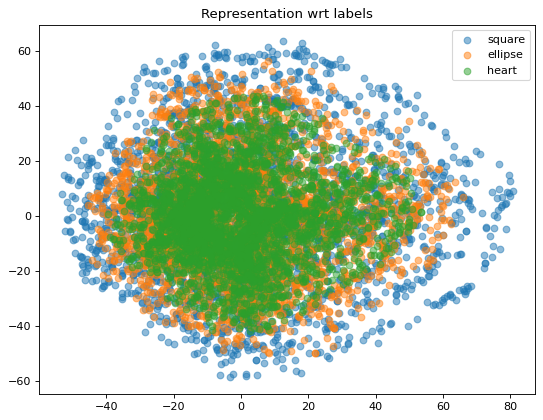

In [ ]:
show_latent_space()

#### Latent dimention 64:

Epoch 1/20
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0837 - val_loss: 0.0335
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0314 - val_loss: 0.0298
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0272 - val_loss: 0.0247
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0190 - val_loss: 0.0180
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 10/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.01

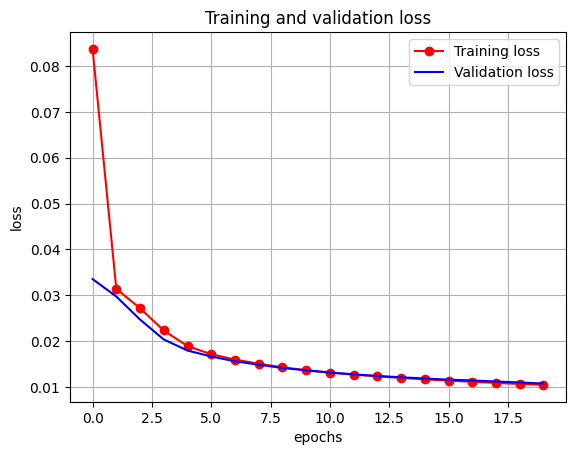

In [ ]:
autoencoder = train_and_plot(latent_dim=64, epochs = 20)

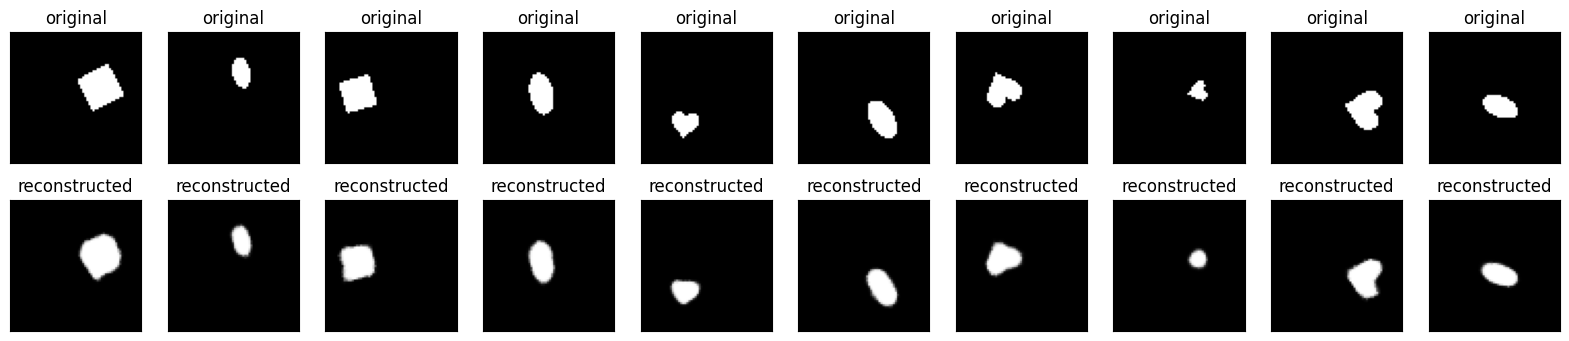

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.5056


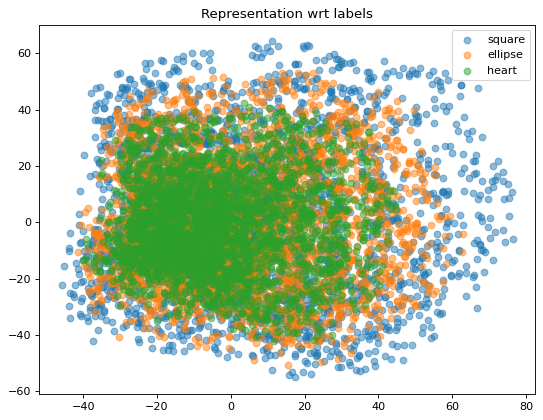

In [ ]:
show_latent_space()

#### Latent dimention 32:

Epoch 1/20
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0944 - val_loss: 0.0348
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0318 - val_loss: 0.0297
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0275 - val_loss: 0.0256
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0238 - val_loss: 0.0223
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0210 - val_loss: 0.0198
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0177 - val_loss: 0.0173
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.01

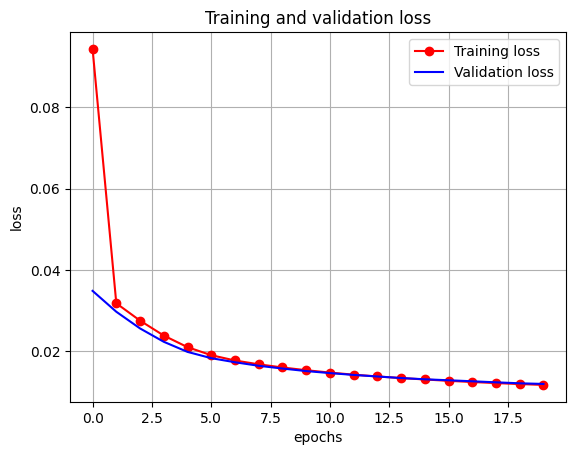

In [ ]:
autoencoder = train_and_plot(latent_dim=32, epochs = 20)

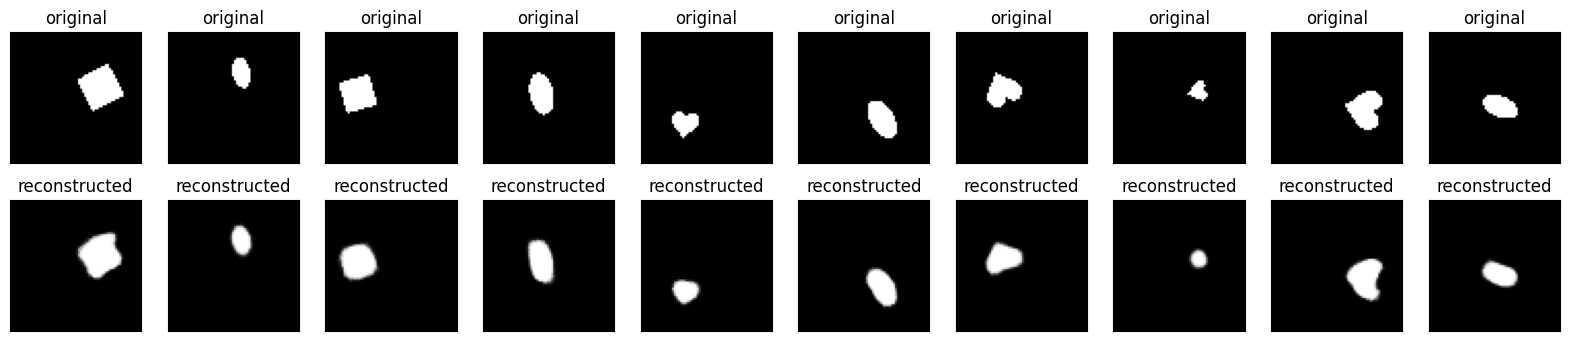

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.5395


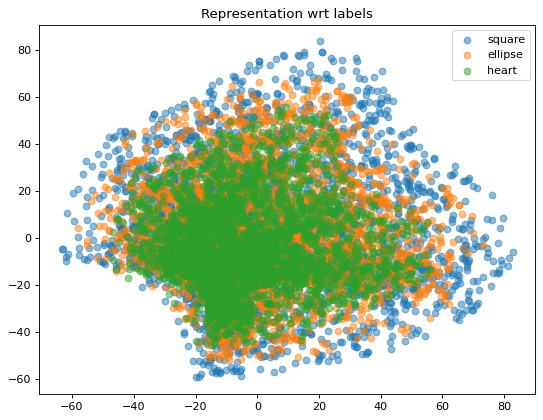

In [ ]:
show_latent_space()

#### Latent dimention 16:

Epoch 1/20
1875/1875 [==============================] - 15s 5ms/step - loss: 0.1009 - val_loss: 0.0417
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0342 - val_loss: 0.0304
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0287 - val_loss: 0.0270
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0258 - val_loss: 0.0245
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0235 - val_loss: 0.0225
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.01

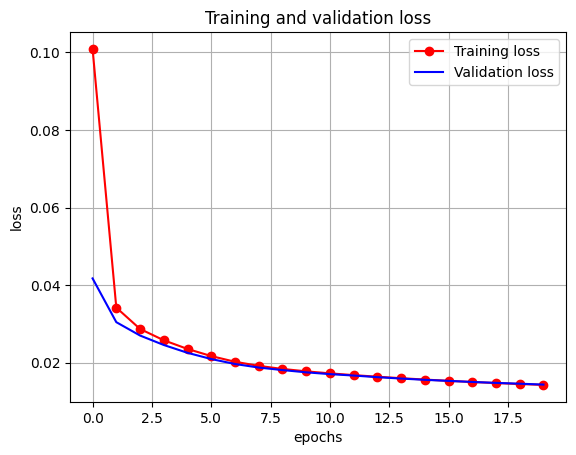

In [ ]:
autoencoder = train_and_plot(latent_dim=16, epochs = 20)

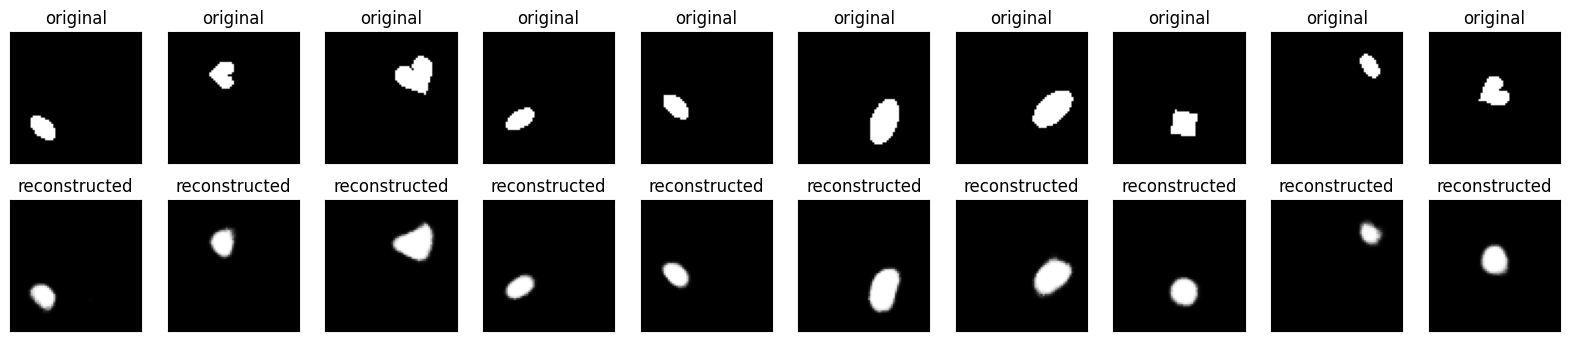

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.5633


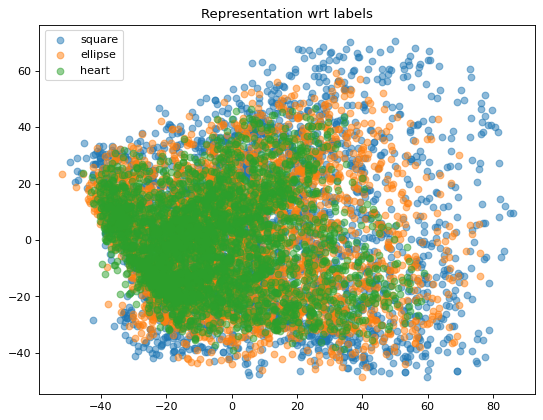

In [ ]:
show_latent_space()

#### Latent dimention 8:

Epoch 1/20
1875/1875 [==============================] - 10s 4ms/step - loss: 0.1119 - val_loss: 0.0514
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0421 - val_loss: 0.0343
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0328 - val_loss: 0.0320
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0314 - val_loss: 0.0308
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0303 - val_loss: 0.0298
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0293 - val_loss: 0.0288
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0284 - val_loss: 0.0279
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0266 - val_loss: 0.0263
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.02

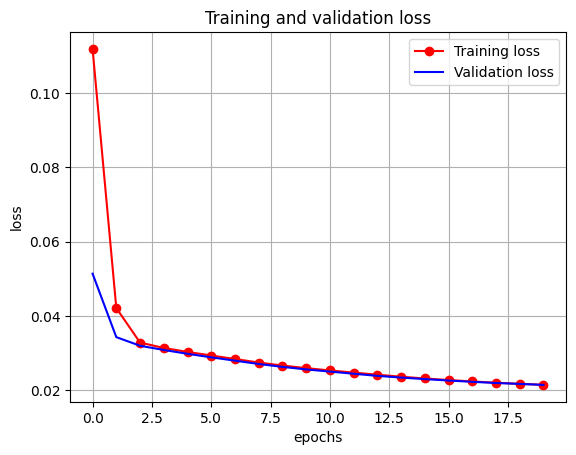

In [ ]:
autoencoder = train_and_plot(latent_dim=8, epochs = 20)

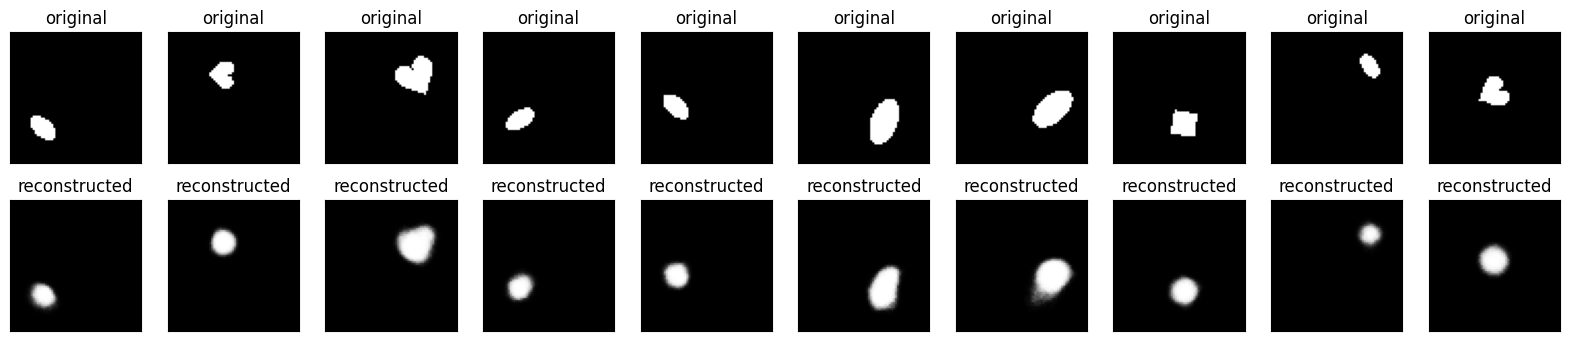

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.4179


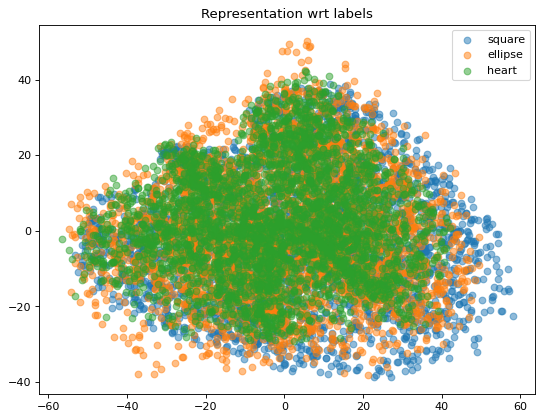

In [ ]:
show_latent_space()

#### Latent dimention 4:

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1644 - val_loss: 0.1108
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0936 - val_loss: 0.0661
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0535 - val_loss: 0.0483
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0457 - val_loss: 0.0439
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0419 - val_loss: 0.0407
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0389 - val_loss: 0.0380
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0368 - val_loss: 0.0364
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0354 - val_loss: 0.0352
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0345 - val_loss: 0.0345
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.03

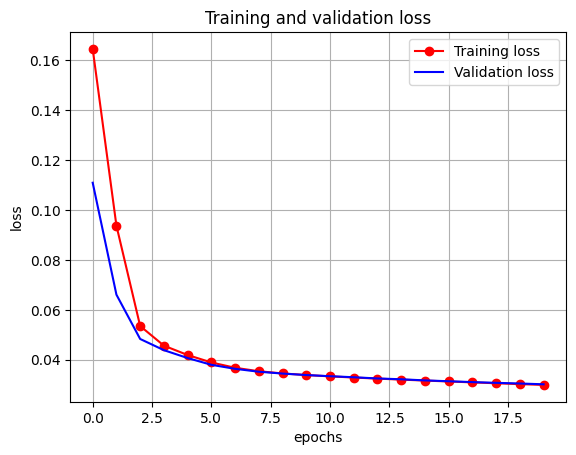

In [ ]:
autoencoder = train_and_plot(latent_dim=4, epochs = 20)

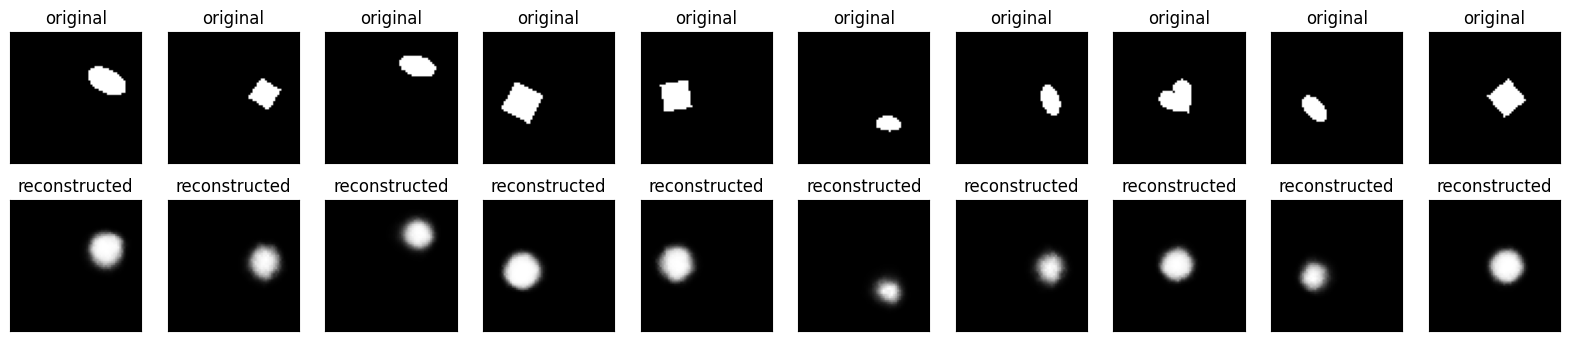

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.4263


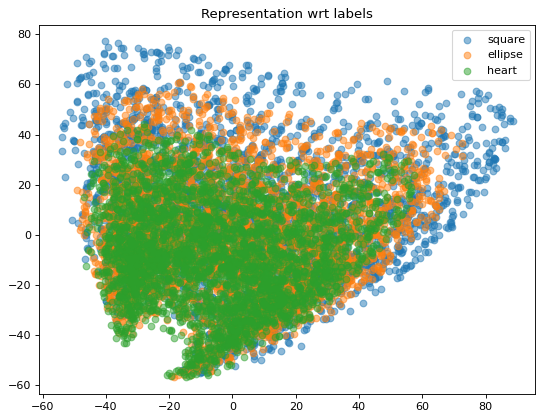

In [ ]:
show_latent_space()

#### Latent dimention 2:

Epoch 1/20
1875/1875 [==============================] - 15s 5ms/step - loss: 0.1945 - val_loss: 0.1649
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1561 - val_loss: 0.1430
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1349 - val_loss: 0.1330
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1317 - val_loss: 0.1320
Epoch 5/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1310 - val_loss: 0.1315
Epoch 6/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1279 - val_loss: 0.1158
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1069 - val_loss: 0.0990
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0915 - val_loss: 0.0863
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0817 - val_loss: 0.0789
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.

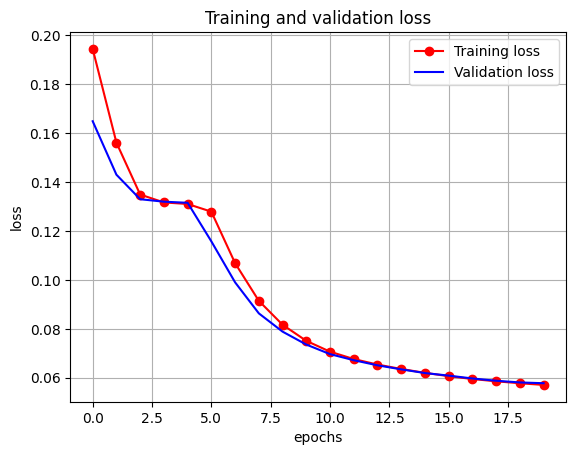

In [ ]:
autoencoder = train_and_plot(latent_dim=2, epochs = 20)

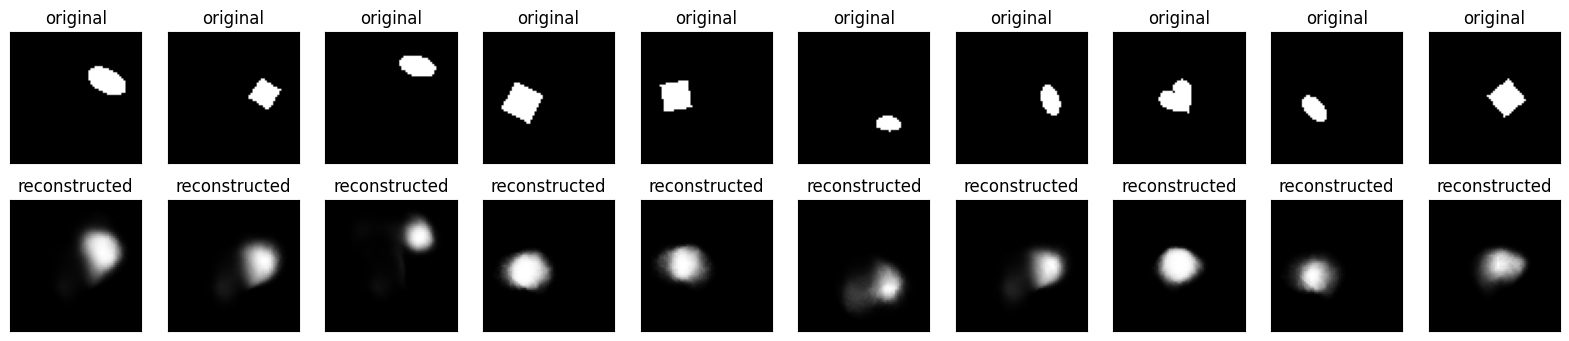

In [ ]:
encoded_imgs, decoded_imgs = show_samples(autoencoder)

Purity: 0.5119


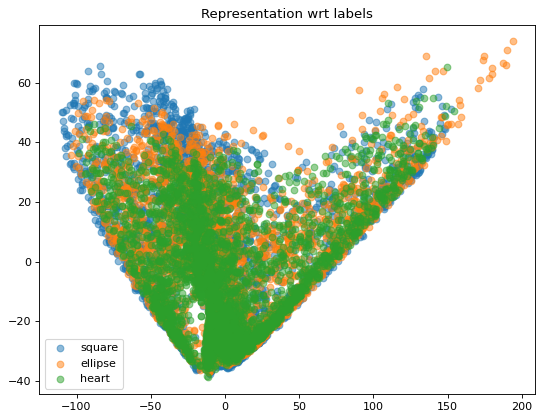

In [ ]:
show_latent_space()

# Pre-trained model

In [ ]:
# Normalize and reshape the data for training:
latents_sampled_ = sample_latent(size=6000)

# Select images
indices_sampled_ = latent_to_index(latents_sampled_)
imgs_sampled_ = imgs[indices_sampled_]
x_train = preprocess(imgs_sampled_)

# Normalize and reshape the data for testing:
latents_sampled = sample_latent(size=1000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]
x_test = preprocess(imgs_sampled)

In [ ]:
# Reshape images to add a single channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_train = np.repeat(x_train, 3, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# Reshape images to remove the redundant dimension
x_train = np.squeeze(x_train, axis=-2)
x_test = np.squeeze(x_test, axis=-2)

In [ ]:
# Normalize and reshape the data for training:
lat_sampled = sample_latent(size=6000)

# Select images
ind_sampled = latent_to_index(lat_sampled)
img_sampled = imgs[ind_sampled]
x_test_new = preprocess(img_sampled)

# Reshape images to add a single channel dimension
x_test_new = np.expand_dims(x_test_new, axis=-1)
x_test_new = np.repeat(x_test_new, 3, axis=-1)
x_test_new = np.squeeze(x_test_new, axis=-2)

## 3 clusters:

In [ ]:
# Create the DenseNet-169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes in dSprites dataset

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, latents_sampled_[:, 1].astype(int), epochs=10, batch_size=32, validation_data=(x_test, latents_sampled[:, 1].astype(int)))

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 157s 175ms/step - loss: 0.1551 - accuracy: 0.9485 - val_loss: 1.2512 - val_accuracy: 0.7310
Epoch 2/10
188/188 [==============================] - 23s 122ms/step - loss: 0.0452 - accuracy: 0.9842 - val_loss: 0.0103 - val_accuracy: 0.9970
Epoch 3/10
188/188 [==============================] - 24s 129ms/step - loss: 0.0205 - accuracy: 0.9943 - val_loss: 0.9659 - val_accuracy: 0.8300
Epoch 4/10
188/188 [==============================] - 22s 119ms/step - loss: 0.0486 - accuracy: 0.9855 - val_loss: 2.6574 - val_accuracy: 0.7020
Epoch 5/10
188/188 [==============================] - 23s 121ms/step - loss: 0.0758 - accuracy: 0.9797 - val_loss: 1.1222 - val_accuracy: 0.9270
Epoch 6/10
188/188 [==============================] - 22s 119ms/step - loss: 0.0183 - accuracy: 0.9950 - val_loss: 1.3557e-04 - val_accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 23s 12

In [ ]:
# Get the intermediate output from the model
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
encoded_images = intermediate_layer_model.predict(x_train)

# Perform k-means clustering on the encoded images
kmeans = KMeans(n_clusters=3)  # Assuming 3 clusters for dSprites dataset
clusters = kmeans.fit_predict(encoded_images)

188/188 [==============================] - 7s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def plot_pca_latent_space(encoded_imgs, labels):

    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(encoded_imgs)

    x, y = data_reduced[:, 0], data_reduced[:, 1]

    plt.figure(figsize=(8, 6), dpi=80)

    df = pd.DataFrame({'x': x, 'y':y, 'c':labels})

    pdf = df[df['c']==0]
    plt.scatter(pdf['x'], pdf['y'], label='square', alpha=0.5)

    pdf = df[df['c']==1]
    plt.scatter(pdf['x'], pdf['y'], label='ellipse', alpha=0.5)

    pdf = df[df['c']==2]
    plt.scatter(pdf['x'], pdf['y'], label='heart', alpha=0.5)
    # plt.scatter(x, y, c=labels, cmap='viridis')

    plt.title("Representation wrt labels")
    plt.legend()
    plt.show()

Purity:  0.9655


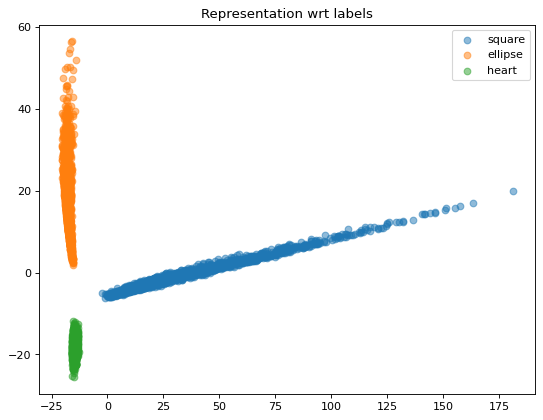

In [ ]:
# Calculate purity with respect to true labels
def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((3, 3))
    for i in range(len(y_true)):
        contingency_matrix[y_pred[i], y_true[i]] += 1
    purity = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    return purity

# Calculate purity with respect to true labels
purity = purity_score(latents_sampled_[:, 1].astype(int), clusters)
print("Purity: ", purity)

plot_pca_latent_space(encoded_images, latents_sampled_[:, 1].astype(int))

In [ ]:
output = model.predict(x_test_new)

188/188 [==============================] - 7s 24ms/step


In [ ]:
# Calculate purity with respect to true labels
purity = purity_score(lat_sampled[:, 1].astype(int), np.argmax(output, axis = 1))
print("Purity: ", purity)


Purity:  1.0


## 6 clusters:

In [ ]:
# Create the DenseNet-169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # Assuming 6 classes in dSprites dataset

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, latents_sampled_[:, 2].astype(int), epochs=10, batch_size=32, validation_data=(x_test, latents_sampled[:, 2].astype(int)))

51877672/51877672 [==============================] - 3s 0us/step
Epoch 1/10
188/188 [==============================] - 150s 153ms/step - loss: 0.9206 - accuracy: 0.6108 - val_loss: 16.3635 - val_accuracy: 0.2590
Epoch 2/10
188/188 [==============================] - 22s 118ms/step - loss: 0.5063 - accuracy: 0.7957 - val_loss: 9.2554 - val_accuracy: 0.5080
Epoch 3/10
188/188 [==============================] - 21s 109ms/step - loss: 0.3996 - accuracy: 0.8567 - val_loss: 8.1071 - val_accuracy: 0.3130
Epoch 4/10
188/188 [==============================] - 21s 111ms/step - loss: 0.3487 - accuracy: 0.8715 - val_loss: 17.0262 - val_accuracy: 0.2020
Epoch 5/10
188/188 [==============================] - 21s 110ms/step - loss: 0.2031 - accuracy: 0.9275 - val_loss: 5.6689 - val_accuracy: 0.2920
Epoch 6/10
188/188 [==============================] - 20s 105ms/step - loss: 0.2629 - accuracy: 0.9058 - val_loss: 4.5890 - val_accuracy: 0.5170
Epoch 7/10
188/188 [==============================] - 21s 110m

In [ ]:
# Get the intermediate output from the model
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
encoded_images = intermediate_layer_model.predict(x_train)

# Perform k-means clustering on the encoded images
kmeans = KMeans(n_clusters=6)  # Assuming 6 clusters for dSprites dataset
clusters = kmeans.fit_predict(encoded_images)

188/188 [==============================] - 6s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def plot_pca_latent_space(encoded_imgs, labels):

    pca = PCA(n_components = 2)
    data_reduced = pca.fit_transform(encoded_imgs)

    x, y = data_reduced[:, 0], data_reduced[:, 1]

    plt.figure(figsize=(8, 6), dpi=80)

    df = pd.DataFrame({'x': x, 'y':y, 'c':labels})

    pdf = df[df['c']==0]
    plt.scatter(pdf['x'], pdf['y'], label='scale 0.5', alpha=0.5)

    pdf = df[df['c']==1]
    plt.scatter(pdf['x'], pdf['y'], label='scale 0.6', alpha=0.5)

    pdf = df[df['c']==2]
    plt.scatter(pdf['x'], pdf['y'], label='scale 0.7', alpha=0.5)
    # plt.scatter(x, y, c=labels, cmap='viridis')

    pdf = df[df['c']==3]
    plt.scatter(pdf['x'], pdf['y'], label='scale 0.8', alpha=0.5)

    pdf = df[df['c']==4]
    plt.scatter(pdf['x'], pdf['y'], label='scale 0.9', alpha=0.5)

    pdf = df[df['c']==5]
    plt.scatter(pdf['x'], pdf['y'], label='scale 1', alpha=0.5)

    plt.title("Representation wrt labels")
    plt.legend()
    plt.show()

Purity:  0.8415


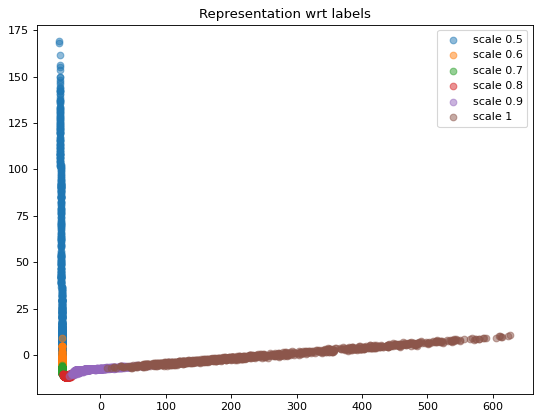

In [ ]:
# Calculate purity with respect to true labels
def purity_score(y_true, y_pred):
    contingency_matrix = np.zeros((6, 6))
    for i in range(len(y_true)):
        contingency_matrix[y_pred[i], y_true[i]] += 1
    purity = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
    return purity

# Calculate purity with respect to true labels
purity = purity_score(latents_sampled_[:, 2].astype(int), clusters)
print("Purity: ", purity)

plot_pca_latent_space(encoded_images, latents_sampled_[:, 2].astype(int))

In [ ]:
output = model.predict(x_test_new)

188/188 [==============================] - 7s 19ms/step


In [ ]:
# Calculate purity with respect to true labels
purity = purity_score(lat_sampled[:, 2].astype(int), np.argmax(output, axis = 1))
print("Purity: ", purity)


Purity:  0.8123333333333334
